In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.dates as mdates
import keras
from pathlib import Path
import shutil
from sklearn.metrics import r2_score
import joblib

from functions_data import *
from functions_model import *
from functions_plot import *
from functions_metrics import *

# Check if GPU is available
print('Available GPUs:', tf.config.list_physical_devices('GPU'))

# To use Python `lambda` function in model layer
keras.config.enable_unsafe_deserialization()

# define some helper functions
def get_best_seed(PATH, MODEL, nb_runs):
    """select the seed that yielded the best model"""
    results = np.zeros(nb_runs)
    for i in range(nb_runs):
        df = pd.read_csv(PATH / str(i) / 'performance.csv')

        # set the index to model name
        df.index = df.Model

        # get the RMSE
        results[i] = df.loc[MODEL, "Test_R2"]

    return np.where(results == np.max(results))[0][0]

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# SEISMICITY figure

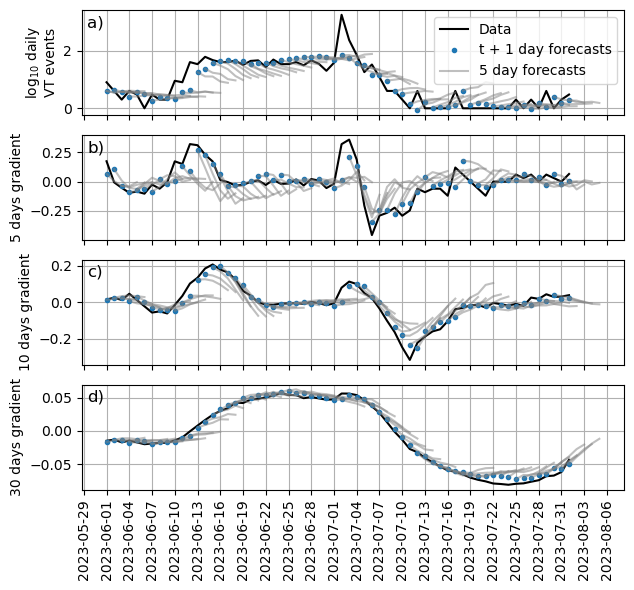

In [9]:
PATH = Path("./models_seismicity")
MODEL = "Transformer"
nb_runs = 10

# We select the seed that yielded the best model
SEED =  get_best_seed(PATH, MODEL, nb_runs)

# load seismicity dataset
data = np.load(PATH / "datasets.npz")

# load trained model
path_model = PATH / str(SEED) / MODEL / 'best_model.keras'
model = keras.models.load_model(path_model)

scaler = joblib.load(PATH / "scaler.pkl")

start = np.datetime64('2023-06-01T00')
end = np.datetime64('2023-08-01T00')

mask = (data['y_test_dates'] >= start) & (data['y_test_dates'] <= end)
dates = data['y_test_dates'][mask]

X_sel = data['X_test'][mask, :,:]
y_sel_sc = data['y_test'][mask, :,:]

predictions_sc = model(X_sel).numpy()

y_sel = scaler.inverse_transform(y_sel_sc)
predictions = scaler.inverse_transform(predictions_sc)

# Figure:
# we plot the data and the prediction of the daily sismicity for the next day in a right subplot
# in a left subplot we plot the same for the 10 day gradient of the seismicity
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6.44,6))

for count, axs in enumerate([ax1, ax2, ax3, ax4]):
    axs.plot(dates, y_sel[:,0,count], "k-", label='Data')
    axs.plot(dates, predictions[:,0,count], ".", label='t + 1 day forecasts')

# a single line for the legend
ax1.plot(dates[0:0+5], predictions[0,:,0].ravel(), color="grey", label='5 day forecasts', alpha=0.5)
ax1.legend(loc="best")

# now plot all 5 day forecasts
for i in range(len(dates)):
    _date = pd.date_range(start=dates[i], periods=5, freq='D')
    for count, axs in enumerate([ax1, ax2, ax3, ax4]):
        axs.plot(_date, predictions[i,:,count].ravel(), color="grey", alpha=0.5)

# Formatting
ax1.set_ylabel("log$_{10}$ daily \nVT events")
ax2.set_ylabel("5 days gradient")
ax3.set_ylabel("10 days gradient")
ax4.set_ylabel("30 days gradient")

# ---- Date formatting ----
# Major ticks every 3 days
annot_ = ["a)", "b)", "c)", "d)"]
for count, axs in enumerate([ax1, ax2, ax3, ax4]):
    axs.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    axs.grid()
    axs.annotate(annot_[count], xy=(0.01, 0.95), xycoords='axes fraction', 
             ha="left", va="top", fontsize=12)

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
# Date format for x-axis
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.setp(ax4.get_xticklabels(), rotation=90, ha="center", va="top")

plt.tight_layout()
plt.savefig("./selected_figures/example_pred_seismicity.pdf")

r2_scores_seis = []
for count,i in enumerate(data['Features']):
    R2_ = r2_score(y_sel[:,:,count].ravel(), predictions[:,:,count].ravel())
    r2_scores_seis.append(R2_)

# GNSS

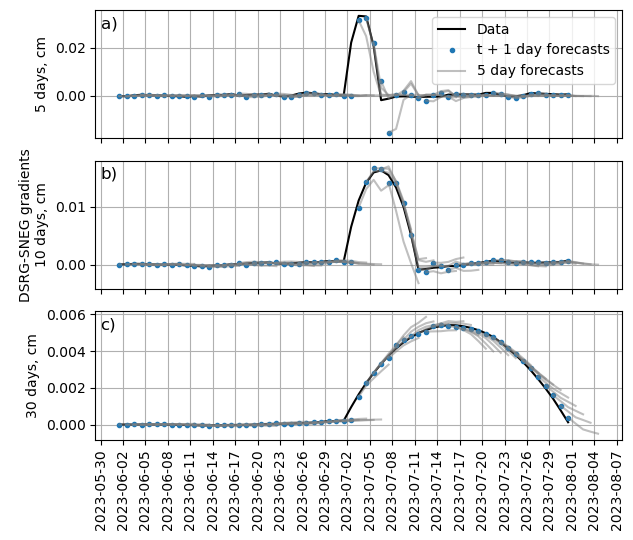

In [10]:
PATH = Path("./models_gnss")
MODEL = "Linear"
nb_runs = 10

# We select the seed that yielded the best model
SEED =  get_best_seed(PATH, MODEL, nb_runs)

# load seismicity dataset
data = np.load(PATH / "datasets.npz")

# load trained model
path_model = PATH / str(SEED) / MODEL / 'best_model.keras'
model = keras.models.load_model(path_model)

scaler = joblib.load(PATH / "scaler.pkl")

start = np.datetime64('2023-06-01T00')
end = np.datetime64('2023-08-01T00')

mask = (data['y_test_dates'] >= start) & (data['y_test_dates'] <= end)
dates = data['y_test_dates'][mask]

X_sel = data['X_test'][mask, :,:]
y_sel_sc = data['y_test'][mask, :,:]

predictions_sc = model(X_sel).numpy()

y_sel = scaler.inverse_transform(y_sel_sc)
predictions = scaler.inverse_transform(predictions_sc)

# Figure:
# we plot the data and the prediction of the daily sismicity for the next day in a right subplot
# in a left subplot we plot the same for the 10 day gradient of the seismicity
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6.44,5.5))

for count, axs in enumerate([ax1, ax2, ax3]):
    axs.plot(dates, y_sel[:,0,count], "k-", label='Data')
    axs.plot(dates, predictions[:,0,count], ".", label='t + 1 day forecasts')

# a single line for the legend
ax1.plot(dates[0:0+5], predictions[0,:,0].ravel(), color="grey", label='5 day forecasts', alpha=0.5)
ax1.legend(loc="best")

# now plot all 5 day forecasts
for i in range(len(dates)):
    _date = pd.date_range(start=dates[i], periods=5, freq='D')
    for count, axs in enumerate([ax1, ax2, ax3]):
        axs.plot(_date, predictions[i,:,count].ravel(), color="grey", alpha=0.5)

# Formatting
ax1.set_ylabel("\n5 days, cm")
ax2.set_ylabel("DSRG-SNEG gradients\n10 days, cm")
ax3.set_ylabel("\n30 days, cm")

# ---- Date formatting ----
# Major ticks every 3 days
annot_ = ["a)", "b)", "c)", "d)"]
for count, axs in enumerate([ax1, ax2, ax3]):
    axs.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    axs.grid()
    axs.annotate(annot_[count], xy=(0.01, 0.95), xycoords='axes fraction', 
             ha="left", va="top", fontsize=12)

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
# Date format for x-axis
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.setp(ax3.get_xticklabels(), rotation=90, ha="center", va="top")

plt.tight_layout()
plt.savefig("./selected_figures/example_pred_gnss.pdf")

r2_scores_gnss = []
for count,i in enumerate(data['Features']):
    R2_ = r2_score(y_sel[:,:,count].ravel(), predictions[:,:,count].ravel())
    r2_scores_gnss.append(R2_)

# BOTH

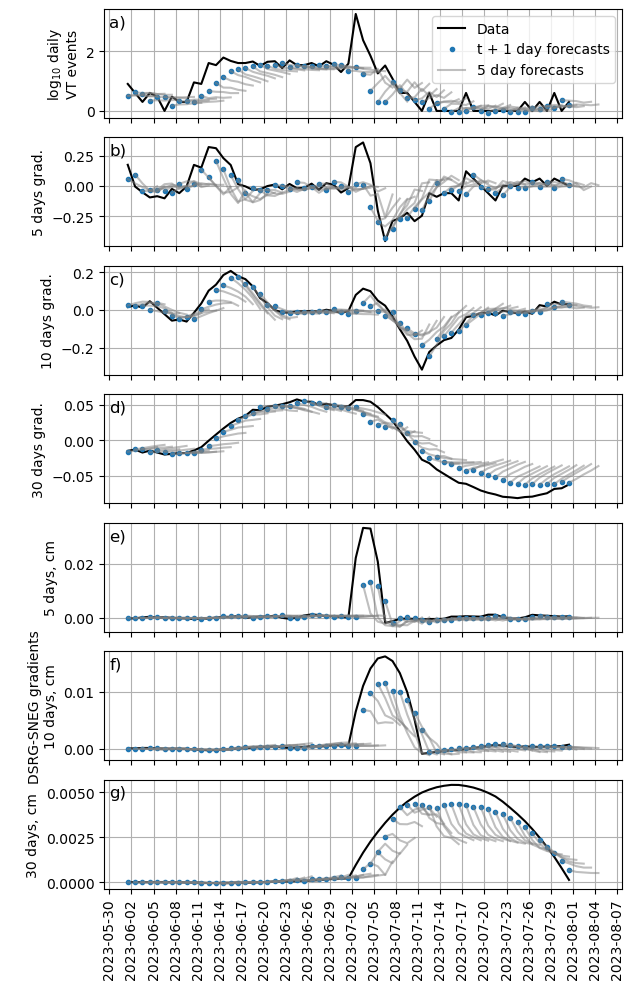

In [11]:
PATH = Path("./models_both")
MODEL = "Transformer"
nb_runs = 10

# We select the seed that yielded the best model
SEED =  get_best_seed(PATH, MODEL, nb_runs)

# select the features for the figure
selection_ = [0, -3, -2, -1, 1, 2, 3]

# load seismicity dataset
data = np.load(PATH / "datasets.npz")

# load trained model
path_model = PATH / str(SEED) / MODEL / 'best_model.keras'
model = keras.models.load_model(path_model)

scaler = joblib.load(PATH / "scaler.pkl")

start = np.datetime64('2023-06-01T00')
end = np.datetime64('2023-08-01T00')

mask = (data['y_test_dates'] >= start) & (data['y_test_dates'] <= end)
dates = data['y_test_dates'][mask]

X_sel = data['X_test'][mask, :,:]
y_sel_sc = data['y_test'][mask, :,:]

predictions_sc = model(X_sel).numpy()

y_sel = scaler.inverse_transform(y_sel_sc)
predictions = scaler.inverse_transform(predictions_sc)

# Figure:
# we plot the data and the prediction of the daily sismicity for the next day in a right subplot
# in a left subplot we plot the same for the 10 day gradient of the seismicity
fig, axs = plt.subplots(7, 1, sharex=True, figsize=(6.44,10))

for count, ax_ in enumerate(axs):
    ax_.plot(dates, y_sel[:,0,selection_[count]], "k-", label='Data')
    ax_.plot(dates, predictions[:,0,selection_[count]], ".", label='t + 1 day forecasts')

# a single line for the legend
axs[0].plot(dates[0:0+5], predictions[0,:,0].ravel(), color="grey", label='5 day forecasts', alpha=0.5)
axs[0].legend(loc="best")

# now plot all 5 day forecasts
for i in range(len(dates)):
    _date = pd.date_range(start=dates[i], periods=5, freq='D')
    for count, ax_ in enumerate(axs):
        ax_.plot(_date, predictions[i,:,selection_[count]].ravel(), color="grey", alpha=0.5)

# Formatting

axs[0].set_ylabel("log$_{10}$ daily \nVT events")
axs[1].set_ylabel("5 days grad.")
axs[2].set_ylabel("10 days grad.")
axs[3].set_ylabel("30 days grad.")
axs[4].set_ylabel("\n5 days, cm")
axs[5].set_ylabel("DSRG-SNEG gradients\n10 days, cm")
axs[6].set_ylabel("\n30 days, cm")
# ---- Date formatting ----
# Major ticks every 3 days
annot_ = ["a)", "b)", "c)", "d)", "e)", "f)", "g)"]
for count, ax_ in enumerate(axs):
    ax_.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax_.grid()
    ax_.annotate(annot_[count], xy=(0.01, 0.95), xycoords='axes fraction', 
             ha="left", va="top", fontsize=12)

axs[-1].xaxis.set_major_locator(mdates.DayLocator(interval=3))
# # Date format for x-axis
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.setp(axs[-1].get_xticklabels(), rotation=90, ha="center", va="top")

plt.tight_layout()
plt.savefig("./selected_figures/example_pred_both.pdf")

r2_scores_both = []
for count,i in enumerate(data['Features']):
    R2_ = r2_score(y_sel[:,:,count], predictions[:,:,count])
    r2_scores_both.append(R2_)

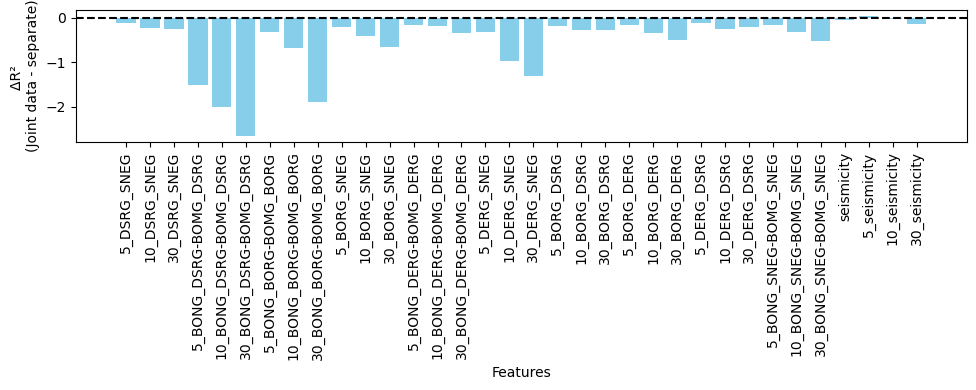

In [13]:
def shorten_feature_names(feature_names):
    short_names = []
    for f in feature_names:
        # Remove 'grad_' prefix and '_interp' suffix
        f_short = f.replace('grad_', '').replace('_interp', '')
        short_names.append(f_short)
    return np.array(short_names)

import numpy as np
import matplotlib.pyplot as plt

# Load datasets
data_gnss = np.load("./models_gnss/datasets.npz", allow_pickle=True)
data_both = np.load("./models_both/datasets.npz", allow_pickle=True)
data_seis = np.load("./models_seismicity/datasets.npz", allow_pickle=True)

features_gnss = shorten_feature_names(data_gnss["Features"])
features_both = shorten_feature_names(data_both["Features"])
features_seis = shorten_feature_names(data_seis["Features"])

# Find the indices of GNSS features in the "both" dataset
common_features_gnss = [f for f in features_gnss if f in features_both]
common_features_seis = [f for f in features_seis if f in features_both]

idx_gnss = [np.where(features_gnss == f)[0][0] for f in common_features_gnss]
idx_both_gnss = [np.where(features_both == f)[0][0] for f in common_features_gnss]

idx_seis = [np.where(features_seis == f)[0][0] for f in common_features_seis]
idx_both_seis = [np.where(features_both == f)[0][0] for f in common_features_seis]

# Make sure r2 scores are numpy arrays
r2_scores_both = np.array(r2_scores_both)
r2_scores_gnss = np.array(r2_scores_gnss)
r2_scores_seis = np.array(r2_scores_seis)

features_diff_gnss = features_both[idx_both_gnss]
r2_diff_gnss = r2_scores_both[idx_both_gnss]-r2_scores_gnss[idx_gnss]

features_diff_seis = features_both[idx_both_seis]
r2_diff_seis = r2_scores_both[idx_both_seis]-r2_scores_seis[idx_seis]

features_diff = np.hstack((features_diff_gnss, features_diff_seis))
r2_diff = np.hstack((r2_diff_gnss, r2_diff_seis))

# Plot comparison for GNSS features
plt.figure(figsize=(10,4))
plt.bar(features_diff, r2_diff, color='skyblue')
plt.axhline(0, color='k', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('ΔR² \n(Joint data - separate)')
#plt.ylim(-1, 1)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("./selected_figures/joint_R2_compare.pdf")
